In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import numpy as np
import torch
import tqdm

import matplotlib.pyplot as plt 

# from ray import tune

import stable_baselines3
from stable_baselines3.common import vec_env, monitor


import autonomous_optimizer
import benchmark

First, open up a terminal window and run
```bash
$ tensorboard --logdir tb_logs
```

Then open up the tensorboard interface, usually at [http://localhost:6006](http://localhost:6006)



## Convex Quadratics

First, we will examine performance on convex quadratic objective functions. We generate 90 convex quadratics in two dimensions with eigenvalues uniformly distributed between 1 and 30 as the train set.

In [3]:
quadratic_dataset = [benchmark.convex_quadratic() for _ in range(90)]

Now we define the RL environment and our model.

In [7]:
quadratic_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(quadratic_dataset, num_steps=40, history_len=25)
    )
]*32)

quadratic_policy = stable_baselines3.PPO('MlpPolicy', quadratic_env, n_steps=2, verbose=0,
                                         tensorboard_log='tb_logs/quadratic')

Train the algorithm on 20 passes over the dataset

In [8]:
quadratic_policy.learn(total_timesteps=20 * quadratic_env.envs[0].num_steps * len(quadratic_dataset))

We will be comparing the RL optimizer to several common convex optimization algorithms. We use Bayesian optimization to find good hyperparameters for this class of problems. And to make this a fair comparison, we will also run 20 passes over all problems in the dataset, just like the RL algorithm gets.

In [185]:
quadratic_tune = {
    "sgd": {"hyperparams": {"lr": 5e-2}},
    "momentum": {"hyperparams": {"lr": 1e-2, "momentum": 0.7}},
    "adam": {"hyperparams": {"lr": 1e-1}},
    "lbfgs": {"hyperparams": {"lr": 1, "max_iter": 1}}
}

Now, let's compare their behavior on an example problem.

In [186]:
problem = benchmark.convex_quadratic()

model0 = problem["model0"]
obj_function = problem["obj_function"]
optimal_x = problem["optimal_x"]
optimal_value = problem["optimal_val"]
A = problem["A"]
b = problem["b"]
    
print(f'Objective function minimum: {optimal_value}')

Objective function minimum: -0.026844769716262817


Run algos with our tuned hyperparams

In [187]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, quadratic_tune, quadratic_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD best loss: -0.026844773441553116
Momentum best loss: -0.026844771578907967
Adam best loss: -0.026755986735224724
LBFGS best loss: -0.026844771578907967
Autonomous Optimizer best loss: -0.024717476218938828


Distance from optimal vs iteration

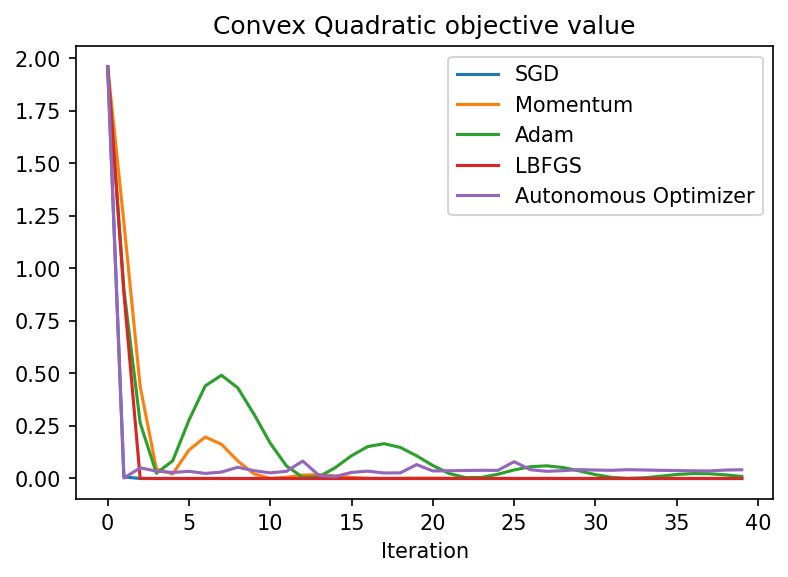

In [188]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Convex Quadratic objective value')
plt.plot(sgd_vals - optimal_value, label='SGD')
plt.plot(momentum_vals - optimal_value, label='Momentum')
plt.plot(adam_vals - optimal_value, label='Adam')
plt.plot(lbfgs_vals - optimal_value, label='LBFGS')
plt.plot(ao_vals - optimal_value, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

Plotting trajectories on a 2-D slice of the parameter space

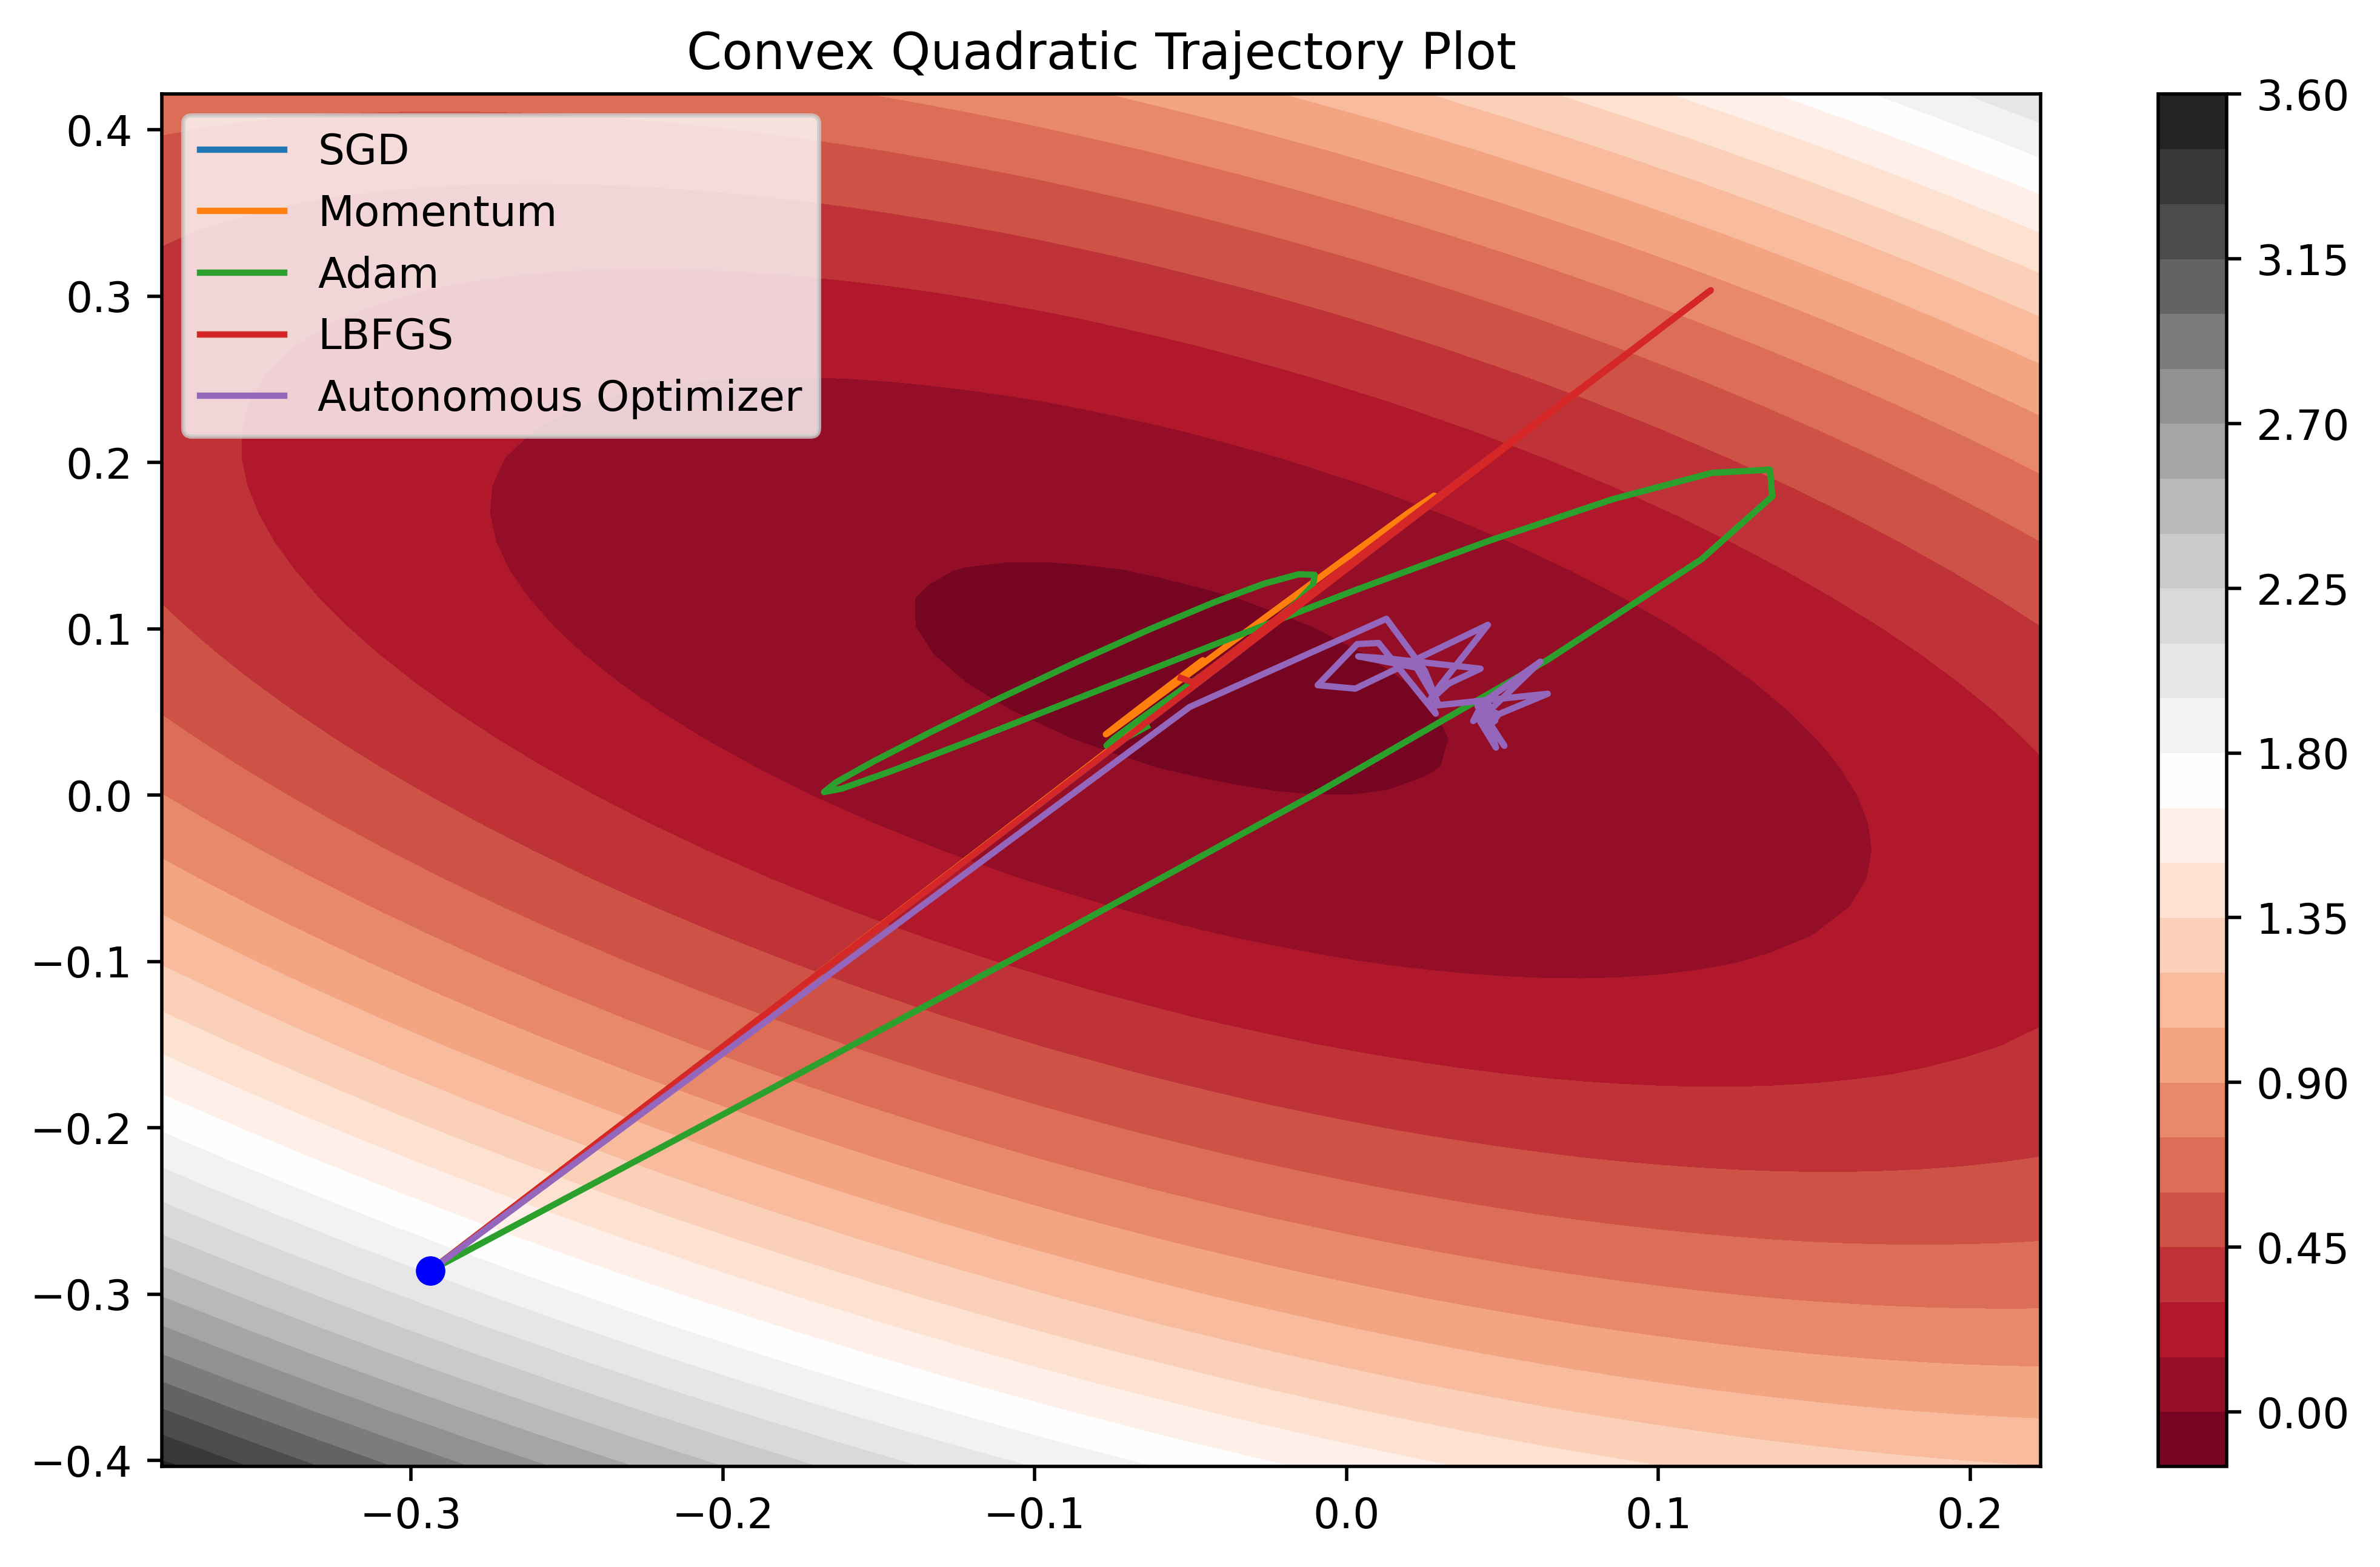

In [189]:
def get_weights(model):
    return model.x[0].item(), model.x[1].item()

def set_weights(model, w1, w2):
    model.x[0] = w1
    model.x[1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Logistic Regression

In [22]:
lr_dataset = [benchmark.logistic_regression() for _ in range(90)]

In [38]:
lr_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(lr_dataset, num_steps=40, history_len=25)
    )
]*32)

lr_policy = stable_baselines3.PPO('MlpPolicy', lr_env, n_steps=1, verbose=0,
                                  tensorboard_log='tb_logs/lr')

In [39]:
lr_policy.learn(total_timesteps=20 * lr_env.envs[0].num_steps * len(lr_dataset))

In [40]:
lr_tune = {
    "sgd": {"hyperparams": {"lr": 1e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.85}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 1, "max_iter": 1}}
}

In [200]:
problem = benchmark.logistic_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]
x, y = problem["data"]

In [201]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, lr_tune, lr_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

sgd_accuracy = np.array([benchmark.accuracy(model, x, y) for model in sgd_traj])
momentum_accuracy = np.array([benchmark.accuracy(model, x, y) for model in momentum_traj])
adam_accuracy = np.array([benchmark.accuracy(model, x, y) for model in adam_traj])
lbfgs_accuracy = np.array([benchmark.accuracy(model, x, y) for model in lbfgs_traj])
ao_accuracy = np.array([benchmark.accuracy(model, x, y) for model in ao_traj])

print(f'\nSGD best accuracy: {sgd_accuracy.max()}')
print(f'Momentum best accuracy: {momentum_accuracy.max()}')
print(f'Adam best accuracy: {adam_accuracy.max()}')
print(f'LBFGS best accuracy: {lbfgs_accuracy.max()}')
print(f'Autonomous optimizer best accuracy: {ao_accuracy.max()}')

SGD best loss: 0.5881528258323669
Momentum best loss: 0.49794071912765503
Adam best loss: 0.4984634518623352
LBFGS best loss: 0.4975156784057617
Autonomous Optimizer best loss: 0.5012771487236023

SGD best accuracy: 0.7900000214576721
Momentum best accuracy: 0.8299999833106995
Adam best accuracy: 0.8299999833106995
LBFGS best accuracy: 0.8199999928474426
Autonomous optimizer best accuracy: 0.8600000143051147


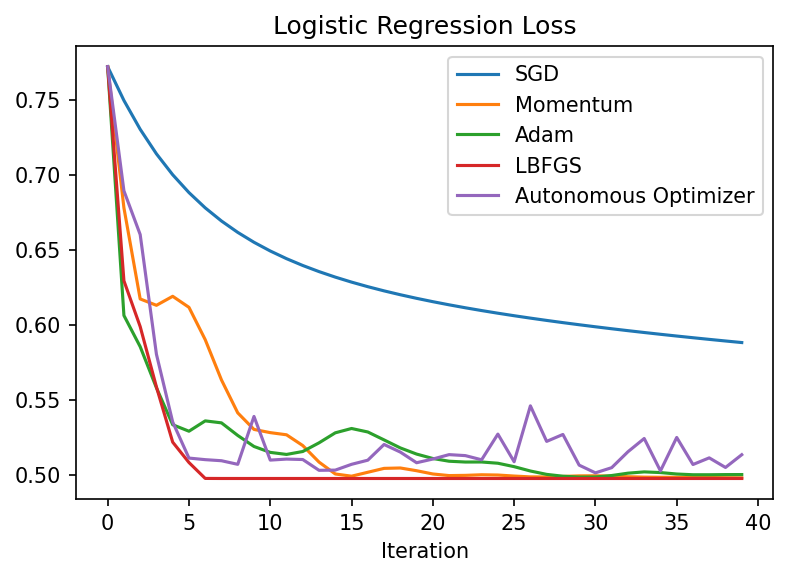

In [202]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Logistic Regression Loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

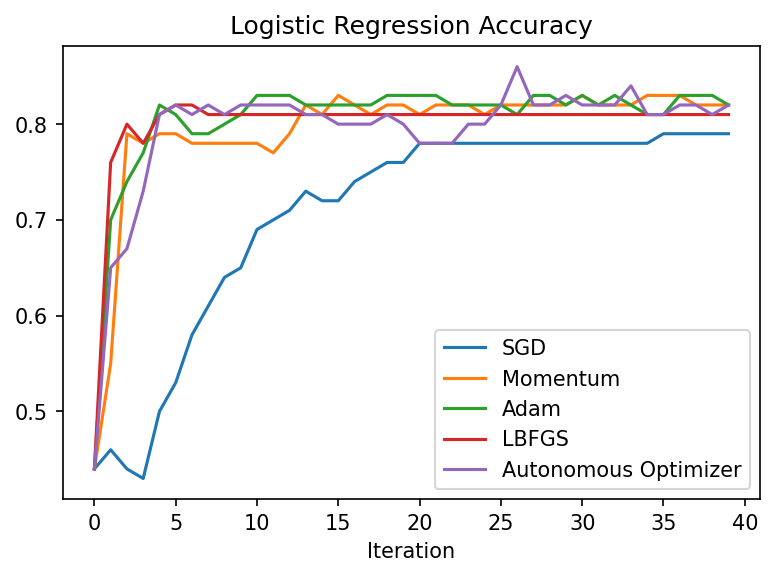

In [203]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Logistic Regression Accuracy')
plt.plot(sgd_accuracy, label='SGD')
plt.plot(momentum_accuracy, label='Momentum')
plt.plot(adam_accuracy, label='Adam')
plt.plot(lbfgs_accuracy, label='LBFGS')
plt.plot(ao_accuracy, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

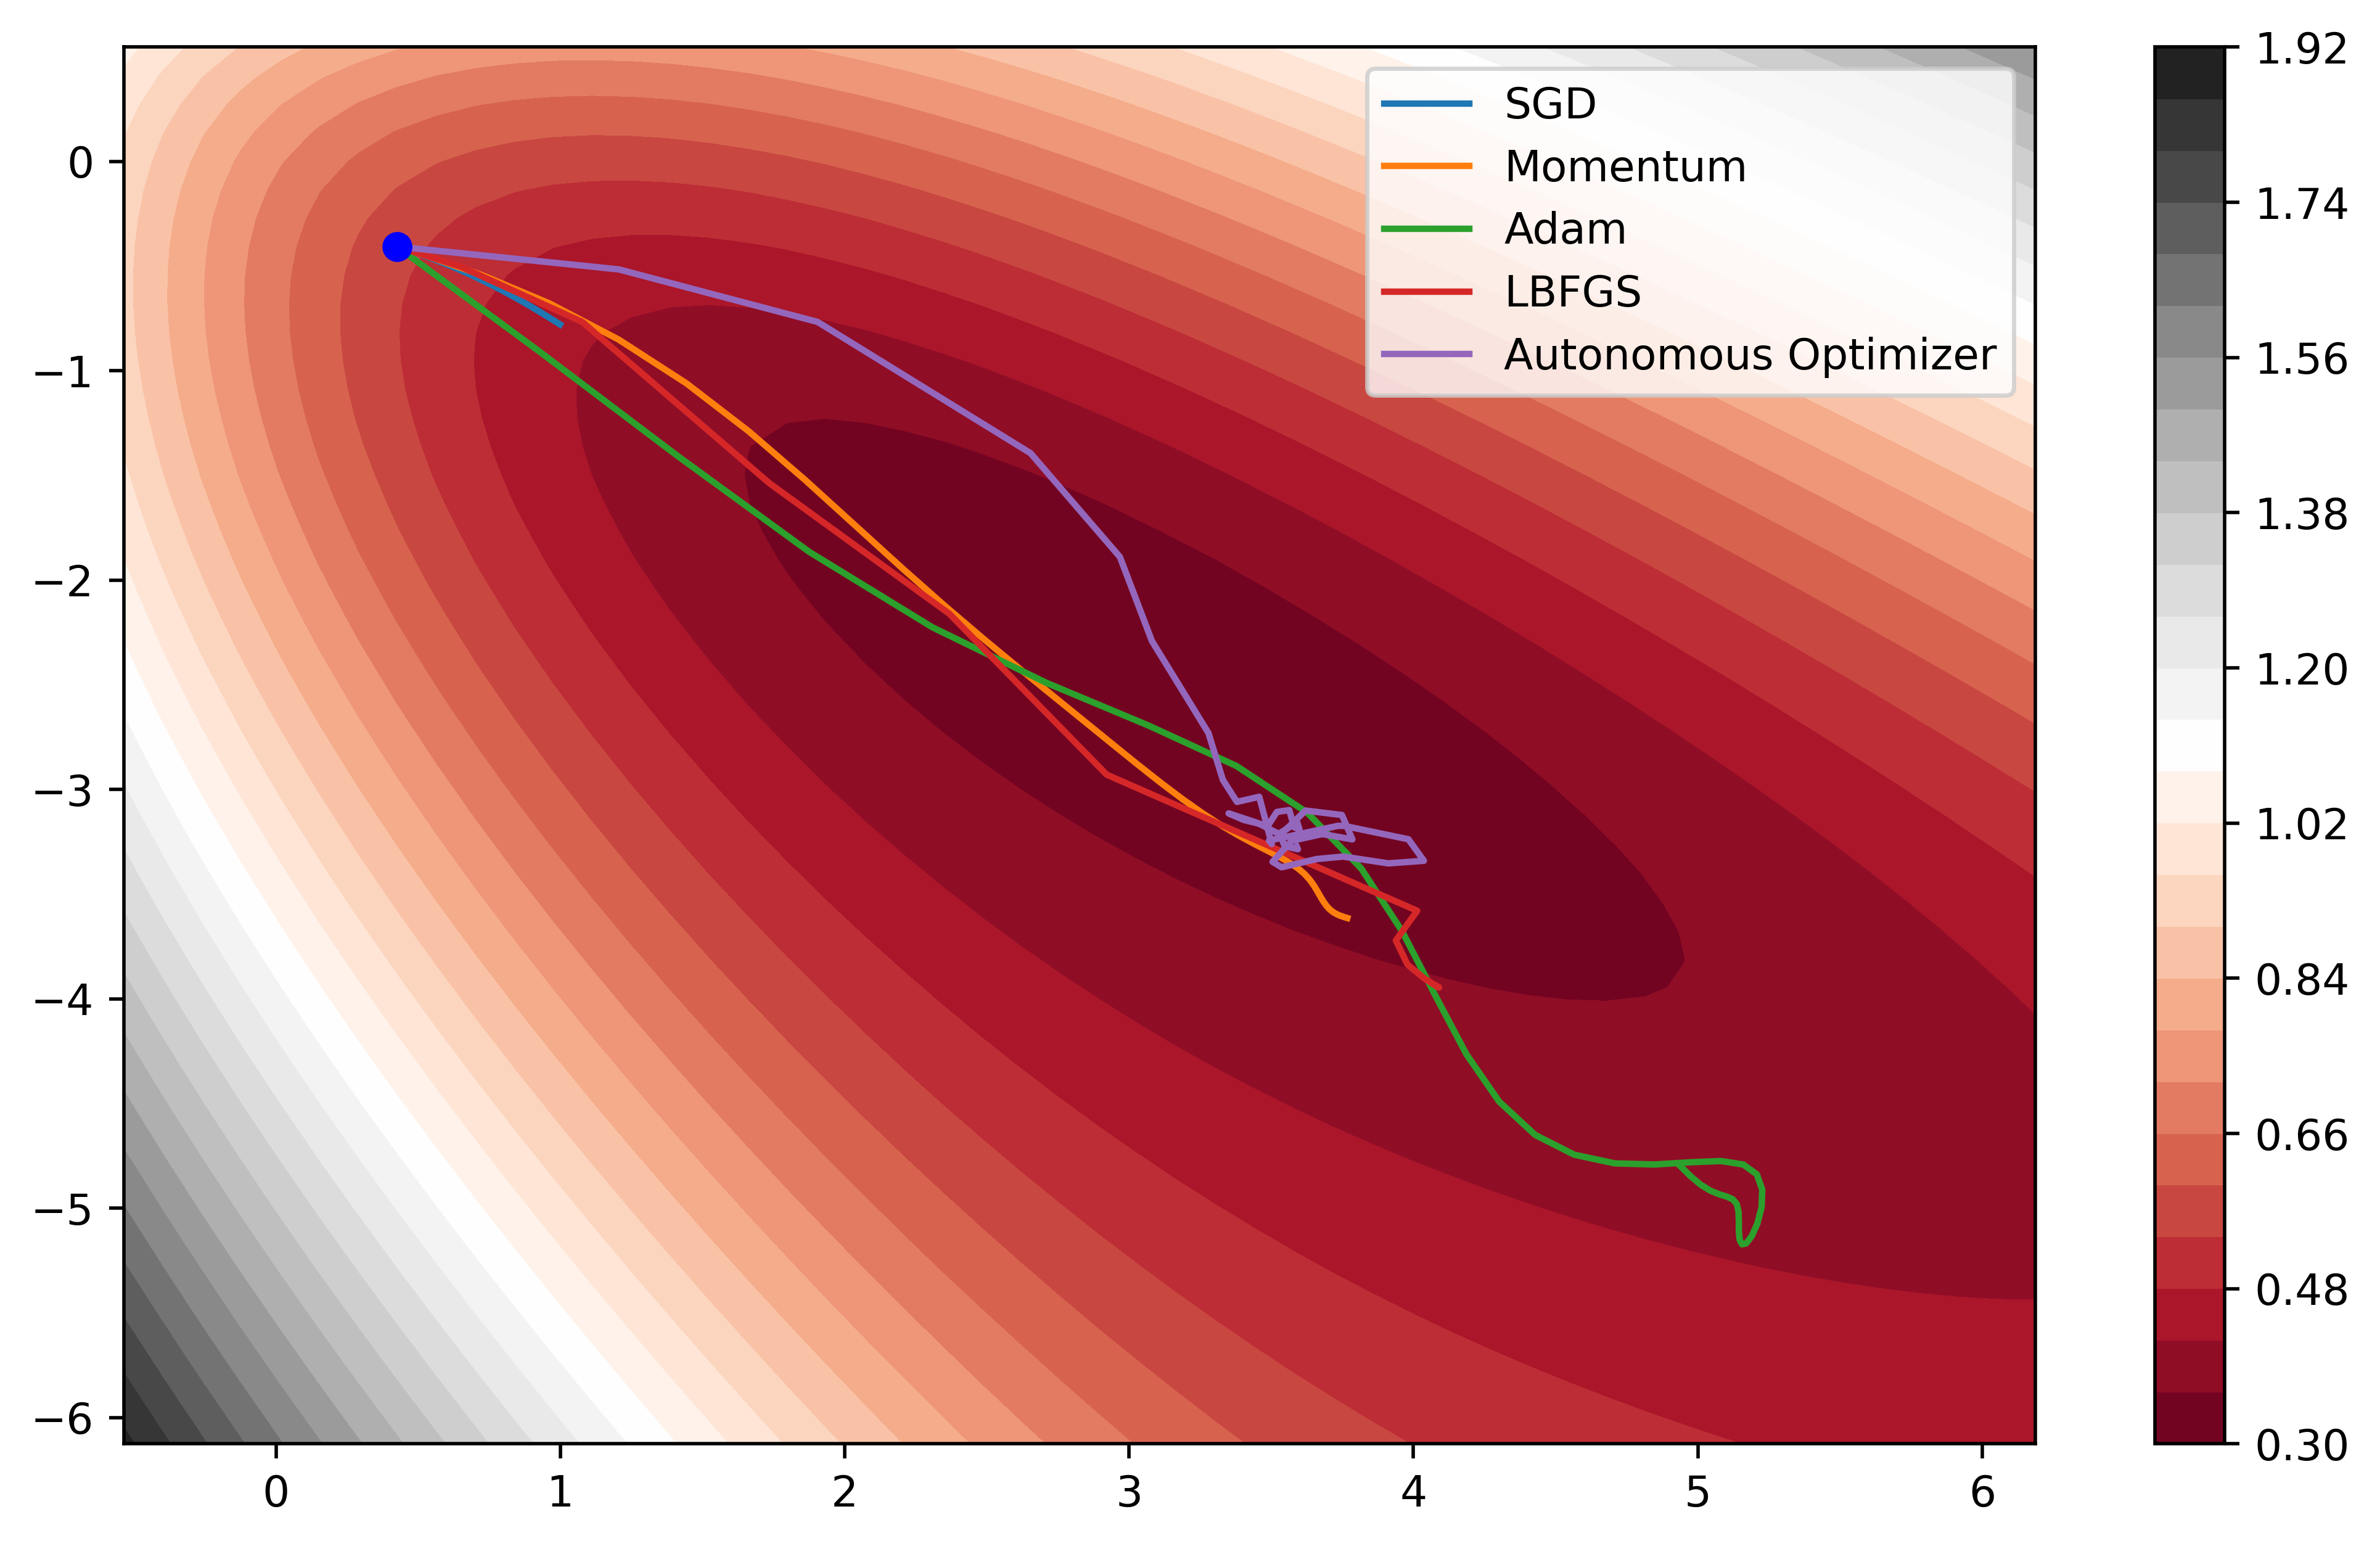

In [67]:
def get_weights(model):
    return model[0].weight[0, 0].item(), model[0].weight[0, 1].item()

def set_weights(model, w1, w2):
    model[0].weight[0, 0] = w1
    model[0].weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Robust Linear Regression

In [70]:
rlr_dataset = [benchmark.robust_linear_regression() for _ in range(120)]

In [71]:
rlr_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(rlr_dataset, num_steps=40, history_len=25)
    )
]*32)

rlr_policy = stable_baselines3.PPO('MlpPolicy', rlr_env, n_steps=1, verbose=0,
                                   tensorboard_log='tb_logs/rlr')

In [72]:
rlr_policy.learn(total_timesteps=125 * rlr_env.envs[0].num_steps * len(rlr_dataset))

In [77]:
rlr_tune = {
    "sgd": {"hyperparams": {"lr": 5e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [84]:
problem = benchmark.robust_linear_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]

In [85]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, rlr_tune, rlr_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD best loss: 0.46200478076934814
Momentum best loss: 0.45280560851097107
Adam best loss: 0.4525027871131897
LBFGS best loss: 0.46206948161125183
Autonomous Optimizer best loss: 0.4565504789352417


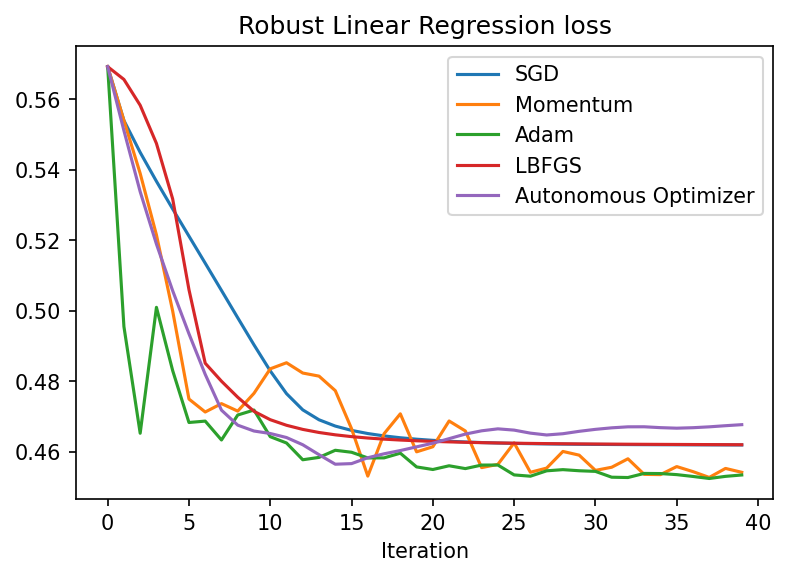

In [86]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Robust Linear Regression loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

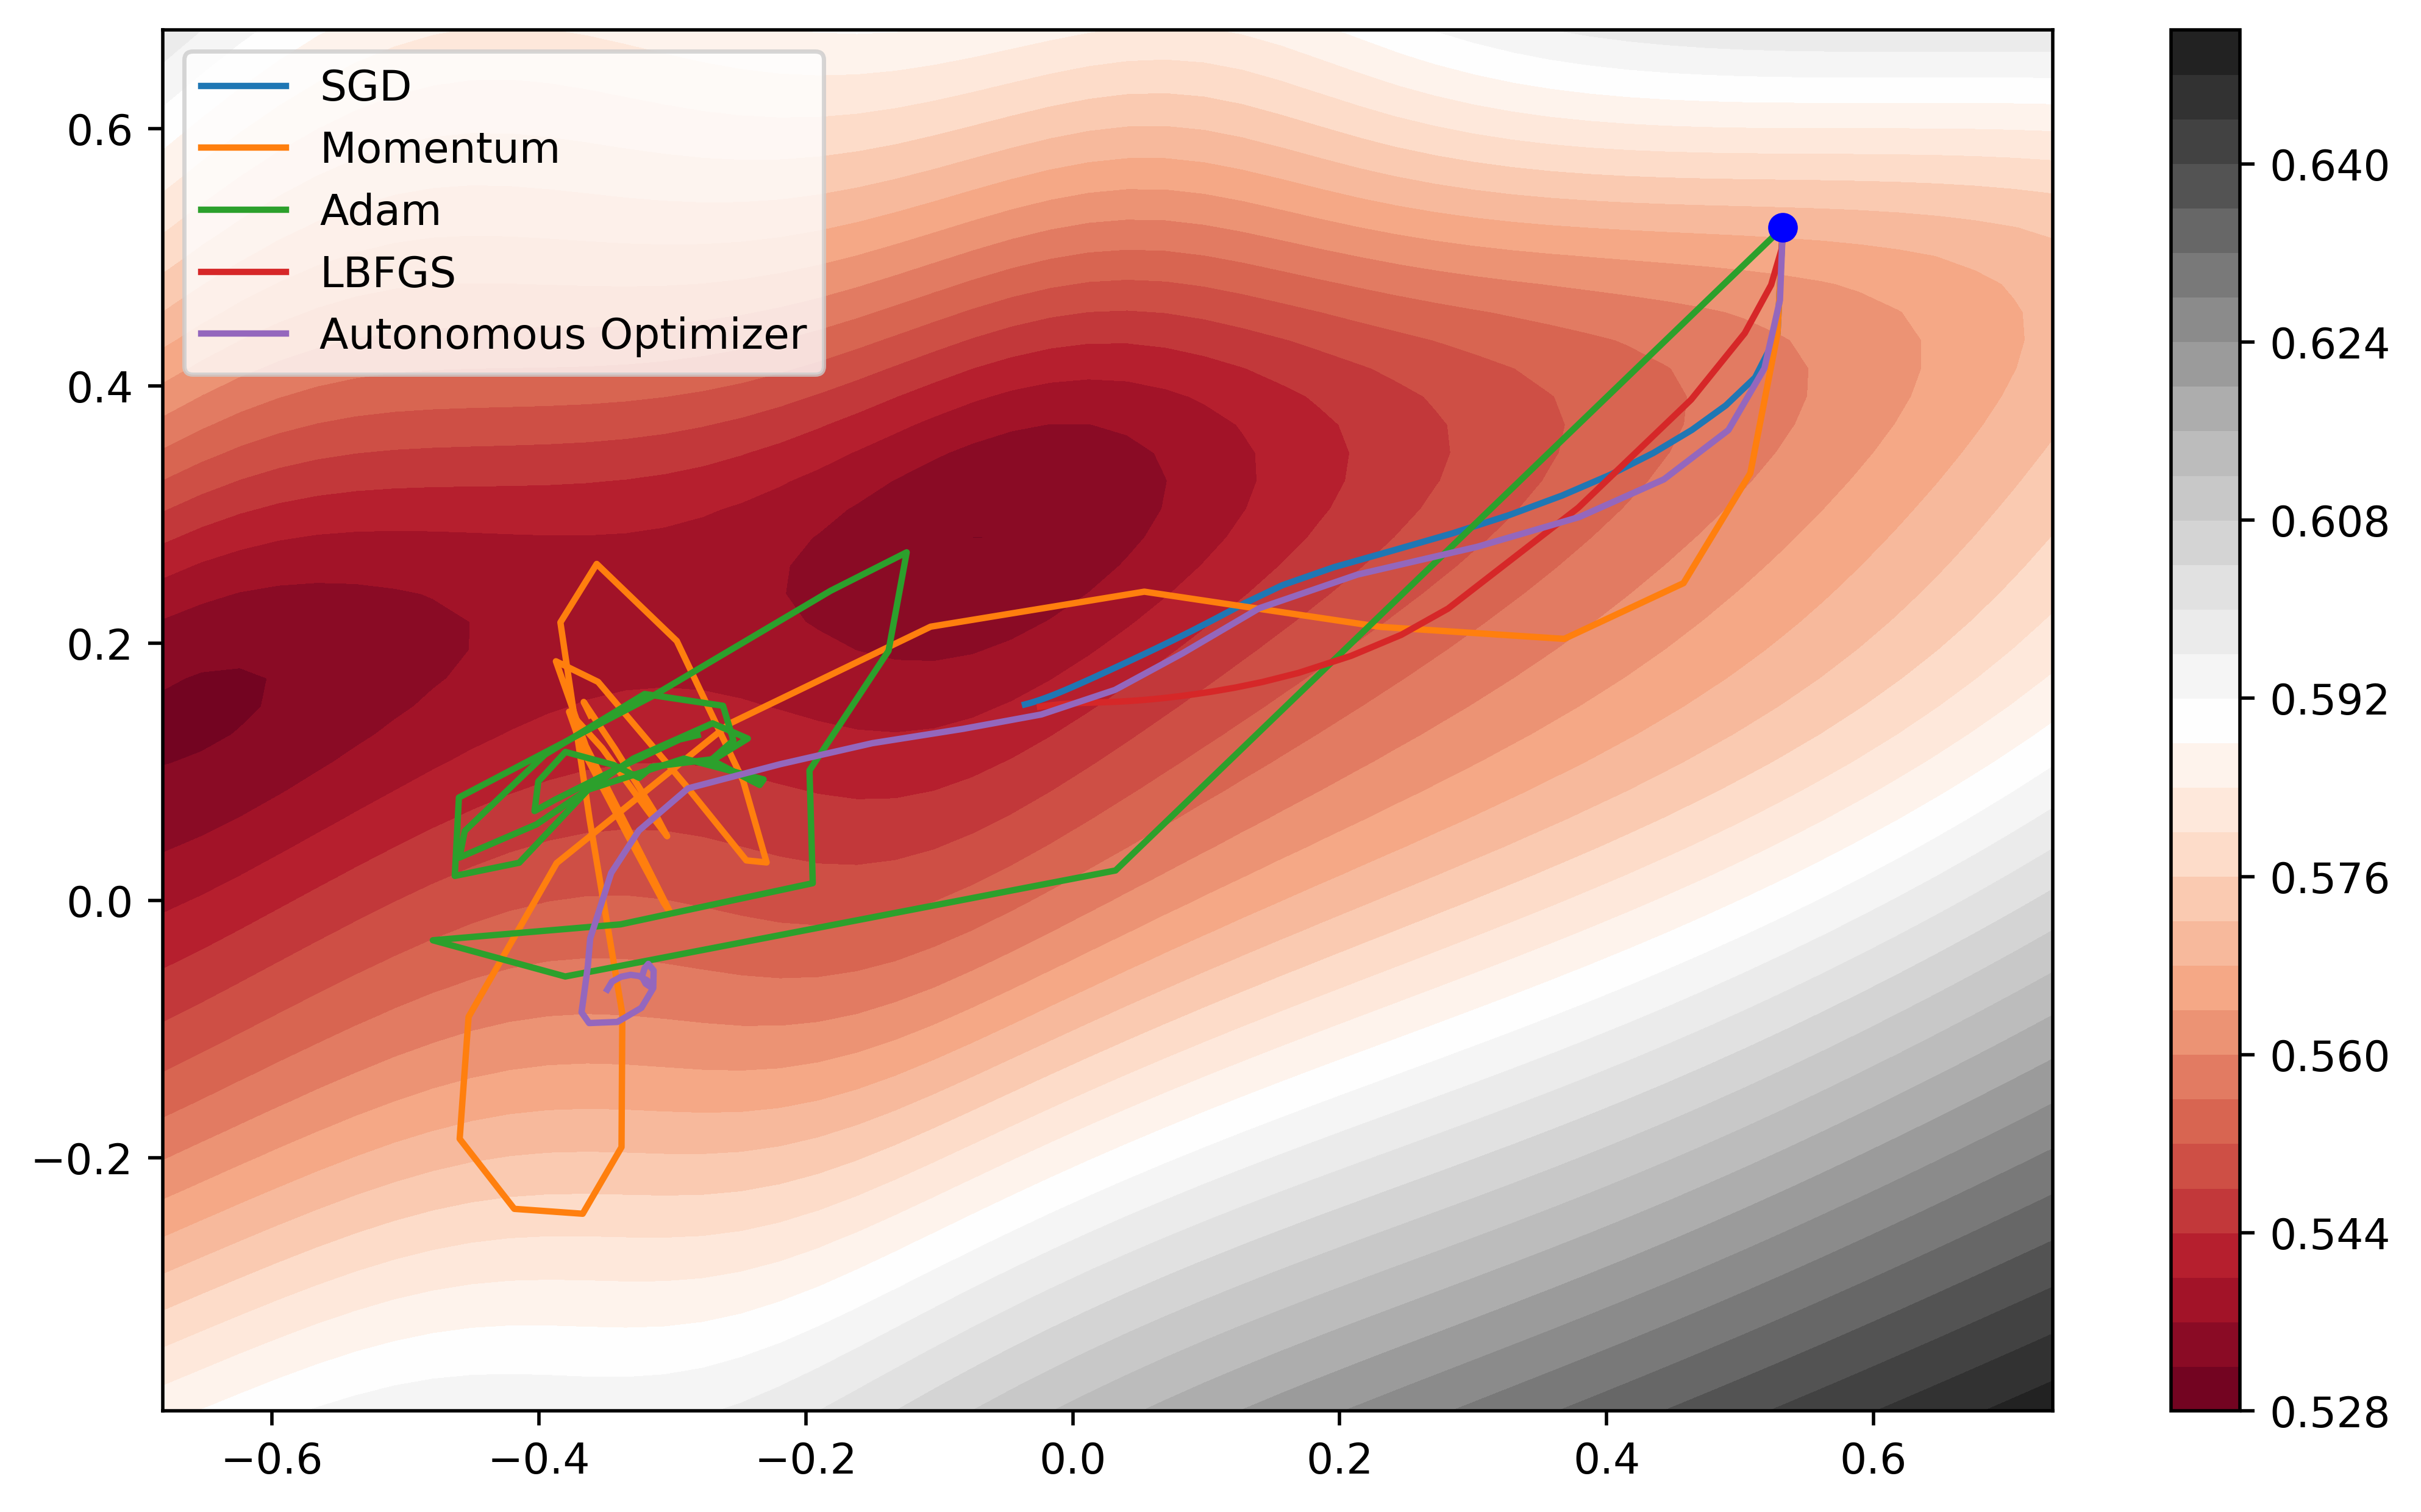

In [87]:
def get_weights(model):
    return model.weight[0, 0].item(), model.weight[0, 1].item()

def set_weights(model, w1, w2):
    model.weight[0, 0] = w1
    model.weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Optimizing a 2-layer neural net

In [88]:
mlp_dataset = [benchmark.mlp() for _ in range(80)]

In [117]:
mlp_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(mlp_dataset, num_steps=40, history_len=25)
    )
]*64)

mlp_policy = stable_baselines3.PPO('MlpPolicy', mlp_env, n_steps=1, verbose=0,
                                   tensorboard_log='tb_logs/mlp')

In [118]:
mlp_policy.learn(total_timesteps=20 * mlp_env.envs[0].num_steps * len(mlp_dataset))

In [119]:
mlp_tune = {
    "sgd": {"hyperparams": {"lr": 3e-1}},
    "momentum": {"hyperparams": {"lr": 3e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [143]:
problem = benchmark.mlp()

model0 = problem["model0"]
obj_function = problem["obj_function"]
x, y = problem["dataset"]

In [144]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, mlp_tune, mlp_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

sgd_accuracy = np.array([benchmark.accuracy(model, x, y) for model in sgd_traj])
momentum_accuracy = np.array([benchmark.accuracy(model, x, y) for model in momentum_traj])
adam_accuracy = np.array([benchmark.accuracy(model, x, y) for model in adam_traj])
lbfgs_accuracy = np.array([benchmark.accuracy(model, x, y) for model in lbfgs_traj])
ao_accuracy = np.array([benchmark.accuracy(model, x, y) for model in ao_traj])

print(f'\nSGD best accuracy: {sgd_accuracy.max()}')
print(f'Momentum best accuracy: {momentum_accuracy.max()}')
print(f'Adam best accuracy: {adam_accuracy.max()}')
print(f'LBFGS best accuracy: {lbfgs_accuracy.max()}')
print(f'Autonomous optimizer best accuracy: {ao_accuracy.max()}')

SGD best loss: 0.56516033411026
Momentum best loss: 0.42796990275382996
Adam best loss: 0.36248478293418884
LBFGS best loss: 0.36160144209861755
Autonomous Optimizer best loss: 0.5619289875030518

SGD best accuracy: 0.75
Momentum best accuracy: 0.8199999928474426
Adam best accuracy: 0.8399999737739563
LBFGS best accuracy: 0.8399999737739563
Autonomous optimizer best accuracy: 0.75


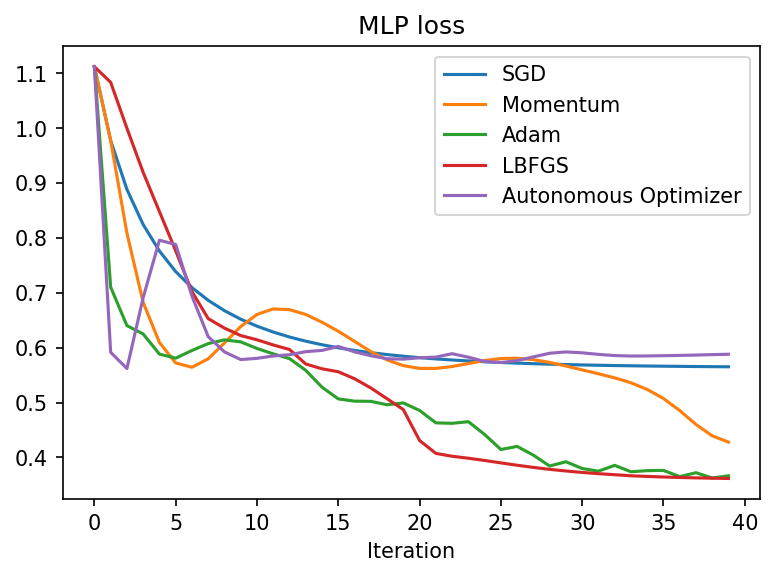

In [149]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

if lbfgs_vals.max() > 1.5:
    plt.ylim(top=1.1)

plt.xlabel('Iteration')
plt.legend()
plt.show()

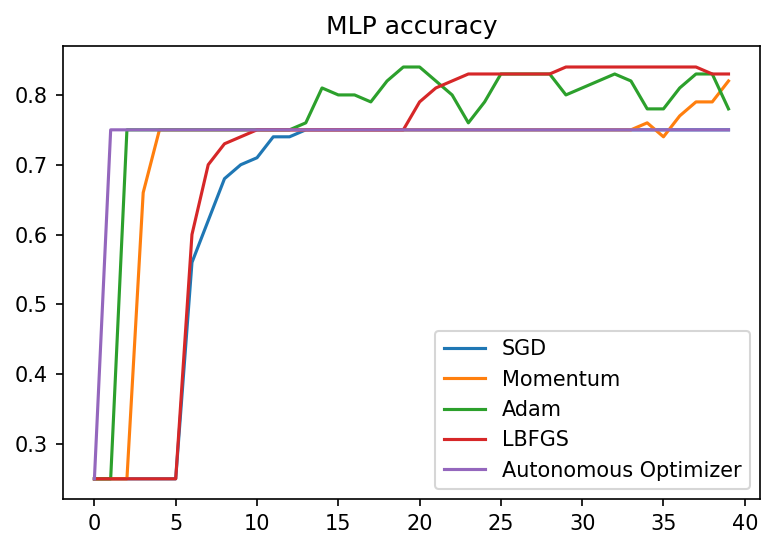

In [146]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP accuracy')
plt.plot(sgd_accuracy, label='SGD')
plt.plot(momentum_accuracy, label='Momentum')
plt.plot(adam_accuracy, label='Adam')
plt.plot(lbfgs_accuracy, label='LBFGS')
plt.plot(ao_accuracy, label='Autonomous Optimizer')

plt.legend()
plt.show()

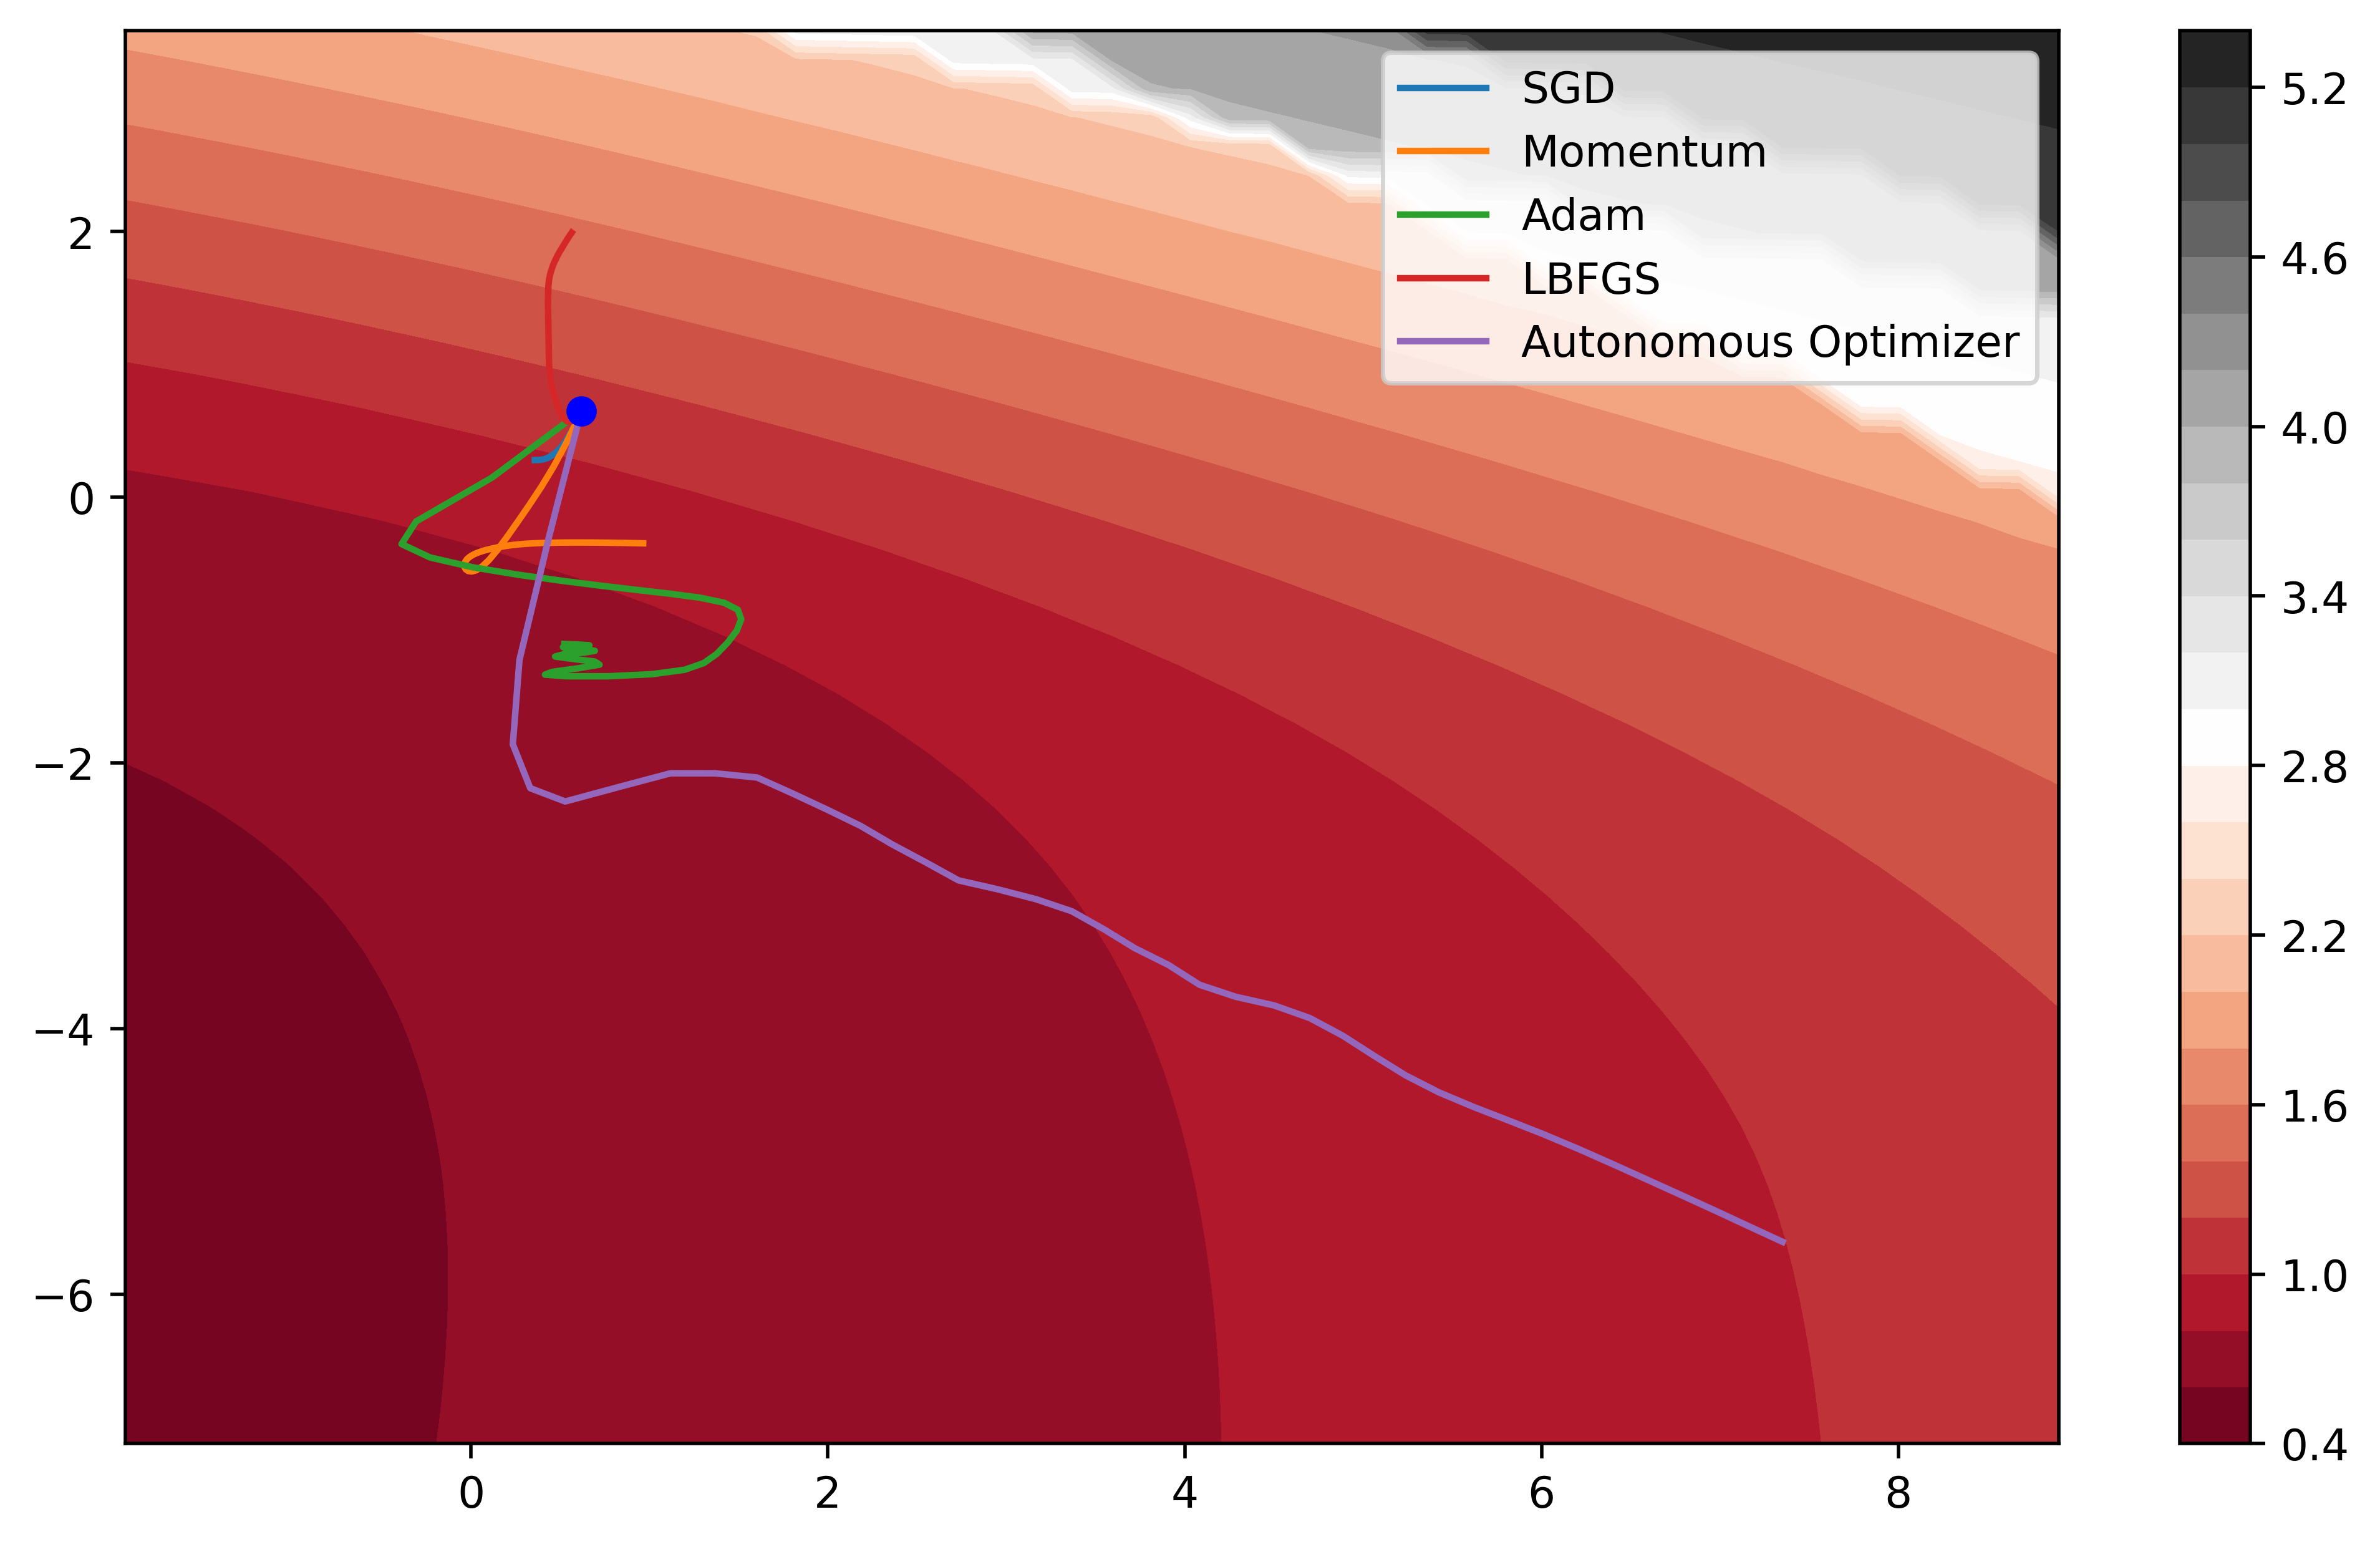

In [147]:
def get_weights(model):
    return model[2].weight[0, 0].item(), model[2].weight[0, 1].item()

def set_weights(model, w1, w2):
    model[2].weight[0, 0] = w1
    model[2].weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)